# EURO STOXX50 - Base GBM Model

In this notebook, we detail our implementation of our base Geometric Brownian Motion model for the [Outperformance Bonus Certificate EURO STOXX 50](https://derivative.credit-suisse.com/ch/ch/en/detail/outperformance-bonus-certificate-euro-stoxx-50/CH1149494077/114949407), a derivative of the SX5E stock.

For our risk-neutral valuation, we perform the following:
1) Look back M time steps for historical data (given an M of 252, we'll take the subset of data from 11 August 2022 to 9 August 2023)
2) Estimate our model parameters ($\sigma = \sqrt{sample\ variance}$) from historical data for the GBM model)
3) Plug our estimated model parameters into our simulation functions and simulate N simulations from 10 August 2023 to our maturity date (e.g. monte carlo, monte carlo with antithetic variates)
4) Calculate our predicted stock price using the mean of the N simulations on our maturity date
5) Calculate our option price by pulling back from the predicted stock price

## Importing Data

In [1]:
# External Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from numba import jit, njit, prange
import time
import datetime
import warnings
import concurrent.futures
import multiprocessing
import ctypes

warnings.filterwarnings("ignore") # Suppress warnings from numba

# Our Code
from payoff_function import PayoffFunctions

We import our historical stock data, taken from [Yahoo Finance's STOXX50E](https://finance.yahoo.com/quote/%5ESTOXX50E/) into a Pandas dataframe called `S_all`:

In [2]:
S_all = pd.read_csv("STOXX50E_2Aug2022_13Nov2023.csv")
S_all = S_all[['Date', 'Adj Close']]

We then import the Euro area yields with 1-year maturity period, taken from the [European Central Bank data portal](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html), as data for our risk-free interest rate:

In [3]:
ir = pd.read_csv("euro_area_1_year_yield_curve.csv").rename(columns={"DATE": "Date", "TIME PERIOD": "Date String", "Yield curve spot rate, 1-year maturity - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_1Y)": "Interest Rate"})
ir

,Date,Date String,Interest Rate
0,2004-09-06,06 Sep 2004,2.298838
1,2004-09-07,07 Sep 2004,2.328891
2,2004-09-08,08 Sep 2004,2.346666
3,2004-09-09,09 Sep 2004,2.308988
4,2004-09-10,10 Sep 2004,2.271566
...,...,...,...
4903,2023-11-07,07 Nov 2023,3.443486
4904,2023-11-08,08 Nov 2023,3.429405
4905,2023-11-09,09 Nov 2023,3.442951
4906,2023-11-10,10 Nov 2023,3.494435


Our timestep (dt) is defined as $\frac{1}{252}$, indicating 1 day out of 252 working days in a year.

In [4]:
dt = 1/252

We define our dates of interest as the dates between 9 Aug 2023 and 9 Nov 2023 (62 days in total):

In [5]:
actual_dates = ir[(ir['Date'] >= '2023-08-09') & (ir['Date'] <= '2023-11-09')]['Date'].values
simulation_dates = ir[(ir['Date'] >= '2023-08-08') & (ir['Date'] <= '2023-11-08')]['Date'].values

## Obtaining Model Parameters from Historical Data
For our base GBM model, we are only interested in $\sigma$, the sample variance of our historical data for each day.

For each day in the sliding window (62 days in total), we look back M days and calculate $\sigma$, starting from 9 August 2023. This gives us a total of 252 trading days from 11 August 2022 to 9 August 2023.

In [6]:
# Main Parameters
M = 252
Nsim = 10000
cpu_count = 4
print(f"M: {M}")
print(f"No. of Simulations (Total): {Nsim}")
print(f"CPU Count: {cpu_count} used / {multiprocessing.cpu_count()} available")

M: 252
No. of Simulations (Total): 10000
CPU Count: 4 used / 12 available


In [7]:
sigma = np.zeros(len(actual_dates), dtype=np.float32)
for i, date in enumerate(simulation_dates):
    date_index = S_all.loc[S_all['Date'] == date].index[0] + 1
    history_data = list(S_all.iloc[date_index-M:date_index, ]['Adj Close'])
    log_history_data = np.log(history_data)
    log_return = log_history_data[1:] - log_history_data[:-1]
    sigma[i] = np.std(log_return) / np.sqrt(dt)

In [8]:
r = ir[ir['Date'].isin(simulation_dates)]['Interest Rate'].values / 100
v = r - sigma**2 / 2
St = S_all[S_all['Date'].isin(simulation_dates)]['Adj Close'].values
T = np.array(range(485, 485-len(actual_dates), -1)) / 252

## Simulating data


In [9]:
# TODO: Shift all simulation functions into a Python file
def simulate_gbm_exact(n_sim, S_0, v, sigma, delta_t, T):
    '''
    GBM simulation using Monte Carlo

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))

    for i in tqdm(range(n_sim)):
    # for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
    return S_t

@njit
def simulate_gbm_exact_jit(n_sim, S_0, v, sigma, delta_t, T):
    '''
    GBM simulation using Monte Carlo

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)

    for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma*np.sqrt(delta_t)*np.random.normal())
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma*np.sqrt(delta_t)*np.random.normal())
    return S_t


@njit
def simulate_gbm_exact_with_delta(Nsim, S0, v, sigma, dt, T, h):
    m = int(T/dt)
    S_minus_h = [[(S0-h) for _ in range(m+1)] for _ in range(Nsim)]
    S = [[(S0) for _ in range(m+1)] for _ in range(Nsim)]
    S_plus_h = [[(S0+h) for _ in range(m+1)] for _ in range(Nsim)]
    for i in range(Nsim):
        for j in range(1, m+1):
            Z = Z = np.random.normal()
            S_minus_h[i][j] = S_minus_h[i][j-1]*np.exp(v*dt+sigma*np.sqrt(dt)*Z)
            S_plus_h[i][j] = S_plus_h[i][j-1]*np.exp(v*dt+sigma*np.sqrt(dt)*Z)
            S[i][j] = S[i][j-1]*np.exp(v*dt+sigma*np.sqrt(dt)*Z)
    
    return S_minus_h, S, S_plus_h

In [10]:
sim_S = simulate_gbm_exact_jit(10, history_data[-1], v[0], sigma[0], dt, T[0])
print(f"No. of timesteps simulated: {len(sim_S[0])}")

No. of timesteps simulated: 486


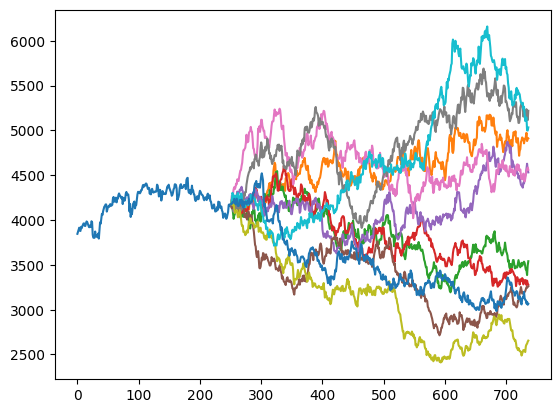

In [11]:
plot1 = pd.Series(history_data, index=np.arange(len(history_data)))
plt.plot(plot1)
for i in range(len(sim_S)):
    plot2 = pd.Series(sim_S[i], index=np.arange(len(history_data)-1, len(history_data)-1+len(sim_S[0])))
    plt.plot(plot2)
plt.show()

# Risk-Neutral Valuation

To calculate T between our initial window date (9 Aug 2023) and the final fixing date (14 July 2025), we use the [timeanddate website](https://www.timeanddate.com/date/workdays.html) and set the country to Germany (a country in the European Union). The number of working days in this range, excluding the end date is 485.

### Normal Monte Carlo Simulation

In [12]:
predicted_derivative_dict = dict()
predicted_derivative_dict['date'] = actual_dates

In [13]:
def run_mc_sensitivities(Nsim, St, v, sigma, dt, T, i, h_coeff=0.001):
    h = h_coeff*St[i]
    S_minus_h, S, S_plus_h  = simulate_gbm_exact_with_delta(Nsim, St[i], v[i], sigma[i], dt, T[i], h)
    
    
    sim_Note = np.exp(-r[i]*T[i])*np.apply_along_axis(PayoffFunctions.payoff_original, 1, S)
    sim_Note_plus_h = np.exp(-r[i]*T[i])*np.apply_along_axis(PayoffFunctions.payoff_original, 1, S_plus_h)
    sim_Note_minus_h = np.exp(-r[i]*T[i])*np.apply_along_axis(PayoffFunctions.payoff_original, 1, S_minus_h)

    note_MC = np.mean(sim_Note)
    note_MC_plus_h = np.mean(sim_Note_plus_h)
    note_MC_minus_h = np.mean(sim_Note_minus_h)
    delta_MC = (note_MC_plus_h-note_MC_minus_h)/2*h
    gamma_MC = (note_MC_plus_h-2*note_MC+note_MC_minus_h)/h**2
    note_MC_var = np.var(sim_Note)/Nsim
    
    return note_MC, note_MC_var, delta_MC, gamma_MC

In [14]:
def run_mc(Nsim, St, v, sigma, dt, T, i):
    sim_S_jit = simulate_gbm_exact_jit(Nsim, St[i], v[i], sigma[i], dt, T[i])
    sim_S_df = pd.DataFrame(sim_S_jit)
    
    sim_Note = np.exp(-r[i]*T[i])*sim_S_df.apply(PayoffFunctions.payoff_original, axis=1)
    note_MC = np.mean(sim_Note)
    note_MC_var = np.var(sim_Note)/Nsim
    
    return note_MC, note_MC_var

In [15]:
# Referencing https://gist.github.com/ltalirz/9220946c5c9fd920a1a2d81ce7375c47
mc_means = np.zeros(len(simulation_dates))
mc_vars = np.zeros(len(simulation_dates))
mc_deltas = np.zeros(len(simulation_dates))
mc_gammas = np.zeros(len(simulation_dates))

mc_jit_start = time.perf_counter()
# for i in tqdm(range(len(simulation_dates))):
#     sim_S_jit = simulate_gbm_exact_jit(Nsim, St[i], v[i], sigma[i], dt, T[i])
#     sim_S_df = pd.DataFrame(sim_S_jit)
    
#     sim_Note = np.exp(-r[i]*T[i])*sim_S_df.apply(PayoffFunctions.payoff_original, axis=1)
#     note_MC = np.mean(sim_Note)
#     note_MC_var = np.var(sim_Note)/Nsim
    
#     mc_means[i] = note_MC
#     mc_vars[i] = note_MC_var
with tqdm(total=len(simulation_dates)) as progress_bar:
    with concurrent.futures.ProcessPoolExecutor(cpu_count) as executor:
        futures = {executor.submit(run_mc_sensitivities, Nsim, St, v, sigma, dt, T, i): i for i in range(len(simulation_dates))}
        for future in concurrent.futures.as_completed(futures):
            i = futures[future]
            mc_means[i], mc_vars[i], mc_deltas[i], mc_gammas[i] = future.result()
            progress_bar.update(1)
mc_jit_end = time.perf_counter()
print(f"Time taken (MC): {mc_jit_end - mc_jit_start}s\n")

lower_percentile = mc_means[0]-1.96*np.sqrt(mc_vars[0])
higher_percentile = mc_means[0]+1.96*np.sqrt(mc_vars[0])
print(f"Note Value (MC) on {actual_dates[0]}: {mc_means[0]}")
print(f"Estimate Variance: {mc_vars[0]}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")
predicted_derivative_dict['MC_Mean'] = mc_means
predicted_derivative_dict['MC_Var'] = mc_vars

100%|███████████████████████████████████████████| 66/66 [00:51<00:00,  1.27it/s]

Time taken (MC): 51.91176553399998s

Note Value (MC) on 2023-08-09: 1393.2170785805438
Estimate Variance: 17.09437915395526
95% Confidence Interval: [1385.113390101966, 1401.3207670591216]


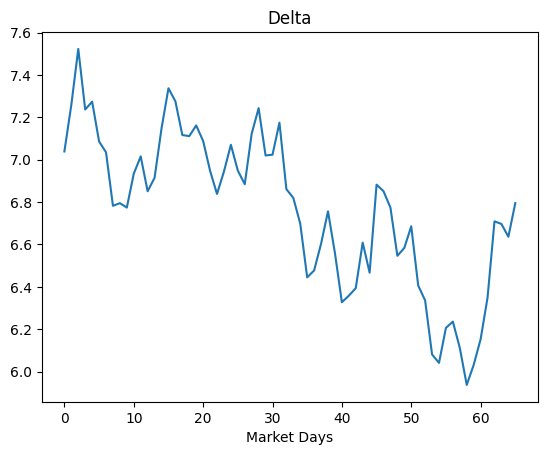

In [16]:
plt.plot(mc_deltas)
plt.xlabel("Market Days")
# plt.ylabel("Delta")
plt.title("Delta")
plt.show()

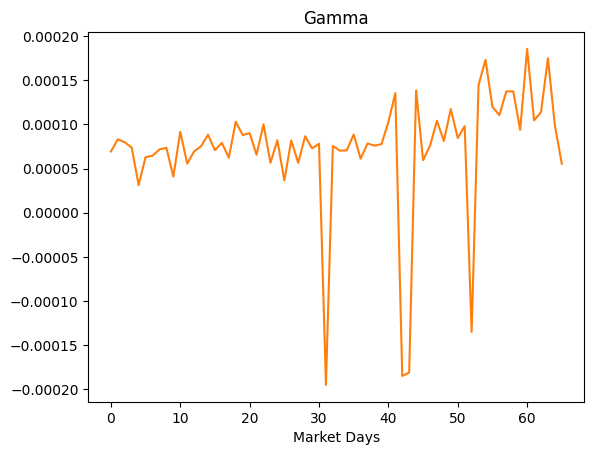

In [17]:
plt.plot(mc_gammas, color="tab:orange")
plt.xlabel("Market Days")
# plt.ylabel("Delta")
plt.title("Gamma")
plt.show()